In [27]:
# Imports
import os;
import pandas as pd
import tqdm
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import math
import time
import json
import requests
from pandas import json_normalize
import os
import csv
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import scikitplot as skplt
import scipy  
from scipy.cluster import hierarchy as hc
from collections import defaultdict
from rfpimp import *
# Machine learning
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from dtreeviz.trees import *
# Then run the code below if you get an error telling you that graphviz isn't in your system path (Windows users)
# https://stackoverflow.com/a/44625895
your_graphviz_install_directory = 'C:/Users/bosem/anaconda3/Library/bin/graphviz'
os.environ["PATH"] += os.pathsep + your_graphviz_install_directory

In [2]:
#Read the data; A is the all-combined dataframe that we will work with
datafolder = os.getcwd()+'\\spadl\\'
spadl_h5 = os.path.join(datafolder,"spadl.h5")
games = pd.read_hdf(spadl_h5,"games")
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")
A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left")
        .merge(results,how="left")
        .sort_values(["game_id","period_id"])
        .reset_index(drop=True)
    )
    A.append(pd.concat([actions],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds"]).reset_index(drop=True)
# A.columns

100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [00:30<00:00, 44.71it/s]


In [3]:
# functions to add Play pattern, throughball, shot cone area and angle
def play_pattern(qualifiers):
    try:
        # Regular Play
        if 22 in qualifiers:
            return 1
        # Fast Break
        elif 23 in qualifiers:
            return 2
        # Set Piece
        elif 24 in qualifiers:
            return 3
        # Corner
        elif 25 in qualifiers:
            return 4
        # Direct Free Kick
        elif 26 in qualifiers:
            return 5
        # Set Piece Throwin
        elif 160 in qualifiers:
            return 6
        else:
            return None
    except ValueError:
        return None
def add_throughball(qualifiers):
    if qualifiers==0:
        return 0
    else:
        if 4 in qualifiers:
            return 1
        else:
            return 0
def get_angle(b):
    b = np.array(b)
    a = np.array([100,45])
    c = np.array([100,55])
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def area(b):
    b = np.array(b)
    x1 = b[0]
    y1 = b[1]
    x2 = 100
    y2 = 35
    x3 = 100
    y3 = 55
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)

In [4]:
#### Add previous actions and qualifers, then extract the shots
#### excluding all penalties and own goals. Then add additional columns - feature engineering
A['prev_actions'] = A['type_name'].shift()
A['prev_qualifiers'] = A['qualifiers'].shift()
shots = A[A.type_name.str.contains('shot')==True]
shots = shots[(shots.type_name != 'shot_penalty')]
shots = shots[shots.result_name != 'owngoal']
shots = shots.reset_index(drop=True)
shots['prev_qualifiers'] = shots.prev_qualifiers.fillna(0).tolist()
shots['play_pattern'] = shots.qualifiers.apply(play_pattern)
### Add throughball qualifer check for previous action 
shots['through_ball'] = shots.prev_qualifiers.apply(add_throughball)
shots['x_dist'] = 100 - shots['start_x']
shots['y_dist'] = abs(50 - shots['start_y'])
### Add distance and angle from center of goal
shots['distance'] = np.sqrt((shots['x_dist']**2 + shots['y_dist']**2))
shots['angle'] = np.degrees(np.arctan2(shots['y_dist'],shots['x_dist']))
### Add previous action tags 
positive_pre_shot = ['cross','pass','dribble','take_on']
for event in positive_pre_shot:
    shots['follows_%s' % event] = np.where(shots['prev_actions'] == event, 1, 0)
for event in ['corner_crossed','corner_short']:
    shots['follows_corner'] = np.where(shots['prev_actions'] == event, 1, 0)
for event in ['freekick_crossed','freekick_short']:
    shots['follows_freekick'] = np.where(shots['prev_actions'] == event, 1, 0)
### Add shot cone angle and area
shots['sca'] = shots[['start_x','start_y']].apply(get_angle, axis=1)
shots['sc'] = shots[['start_x','start_y']].apply(area, axis=1)

In [5]:
# ppndict = {25: 'FromCorner', 22: 'RegularPlay', 26: 'DirectFreekick', 23: 'FastBreak', 24: 'SetPiece',160: 'ThrowinSetPiece',
#           4: 'Throughball'}

In [6]:
# kv = []
# for i in range(len(A.qualifiers)):
#     if(pd.isnull(A.qualifiers[i])):
#         continue
#     else:
#         for k,v in A.qualifiers[i].items():
# #             print(i)
#             if(v.isalpha()):
#                 kv.append((k,v))
# kv = list(set(kv))
# for i in range(len(list(set(kv)))):
#     print(list(set(kv))[i])

In [7]:
# shots.prev_actions.unique()

In [8]:
# shots.columns

In [13]:
feature_cols = ['start_x', 'start_y', 'bodypart_id',
       'type_id','play_pattern', 'through_ball', 'distance','angle','follows_cross', 'follows_pass',
        'follows_dribble', 'follows_take_on',
       'follows_corner', 'follows_freekick','sca','sc']
shots_final = shots[feature_cols]
# Check for missing values
print(shots_final.isnull().sum())

start_x             0
start_y             0
bodypart_id         0
type_id             0
play_pattern        0
through_ball        0
distance            0
angle               0
follows_cross       0
follows_pass        0
follows_dribble     0
follows_take_on     0
follows_corner      0
follows_freekick    0
sca                 0
sc                  0
dtype: int64


In [17]:
labels = shots['result_id']

In [18]:
# First Try : Random Forest
X = shots_final
y = labels
 
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=y, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1
 
loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.08425


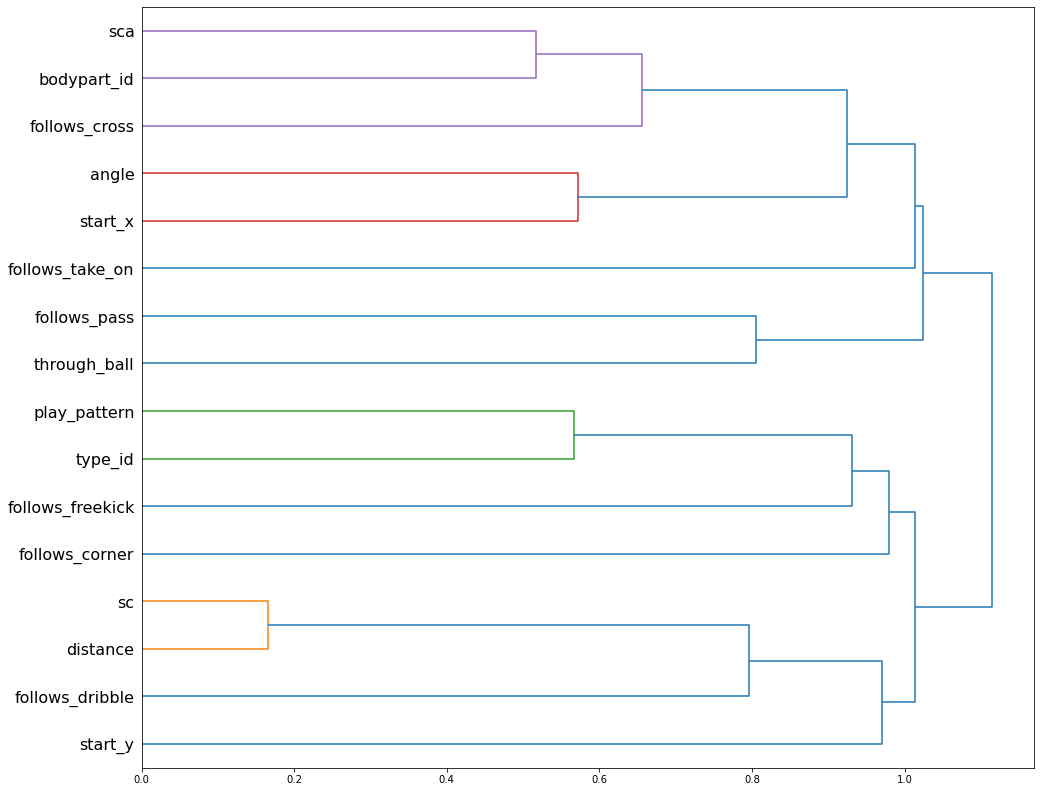

In [19]:
# Dendrogram
from numpy.random import rand
from numpy.random import seed
seed(42)
copyX = X + rand(*X.shape) / 100000.0
# Create dendrogram to show correlations between features
# np.seterr(divide='ignore', invalid='ignore')
def dendrogram(X):
    # Compare features using rank correlation
    # https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,14))
    dendrogram = hc.dendrogram(z, labels=X.columns.tolist(), orientation='right', leaf_font_size=16)
    plt.show()
    return 
dendrogram(X)

In [20]:
# Try removing most correlated features in turn to see what happens
# Each line of feats represents a group of correlated features
feats = ['sc', 'distance']

print('original', "{0:.5f}".format(loss))
for feat in feats:
    loss_feats = get_loss(X=X.drop(feat, axis=1))   
    print(feat, "{0:.5f}".format(loss_feats))

original 0.08425
sc 0.08400
distance 0.08464


In [21]:
X1 = X.drop(['sc'], axis=1)
# X2 = X1.drop(['shot_body_part_name', 'shot_one_on_one','shot_open_goal'], axis=1)
loss1 = get_loss(X=X1)
print('Brier loss:', "{0:.5f}".format(loss1))

Brier loss: 0.08400


In [22]:
# Create a held-out set to properly test our final model
# We will use cross-validation on the training set to tune parameters, then test on unseen data
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20, shuffle=True, stratify=y, random_state=42)

In [23]:
# binary:logistic is an objective function for binary classification that outputs probability estimates - ideal for us
# See https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))
# Get predicted probabilities
y_pred_proba_xgb = xgb.predict_proba(X_test)[:,1]
# Print results
print('Actual goals:', sum(y_test))
print('Predicted goals (xgb):', '{0:.2f}'.format(sum(y_pred_proba_xgb)))

Brier loss: 0.07893
Actual goals: 656
Predicted goals (xgb): 649.55


In [24]:
# Try calibrating the probabilities
calibrated_xgb = CalibratedClassifierCV(xgb, cv=cv, method='sigmoid')
calibrated_xgb.fit(X_train, y_train)
scores = cross_val_score(calibrated_xgb, X_train, y_train, cv=cv, scoring='brier_score_loss')
y_pred_proba_calibrated_xgb = calibrated_xgb.predict_proba(X_test)[:,1]
# Print results
print('Actual goals:', sum(y_test))
print('Predicted goals (calibrated_xgb):', '{0:.2f}'.format(sum(y_pred_proba_calibrated_xgb)))
print('Brier loss (xgb):', '{0:.5f}'.format(brier_score_loss(y_test, y_pred_proba_calibrated_xgb)))
y_pred_calibrated_xgb = calibrated_xgb.predict(X_test)

Actual goals: 656
Predicted goals (calibrated_xgb): 655.30
Brier loss (xgb): 0.07881


In [25]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred_calibrated_xgb), "\n")
print(metrics.classification_report(y_test, y_pred_calibrated_xgb))

accuracy: 0.9047829937998229 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6118
           1       0.55      0.09      0.15       656

    accuracy                           0.90      6774
   macro avg       0.73      0.54      0.55      6774
weighted avg       0.88      0.90      0.87      6774



<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

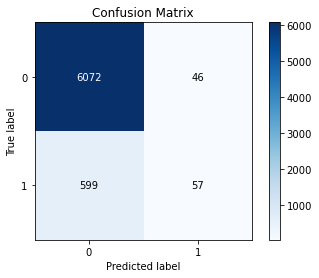

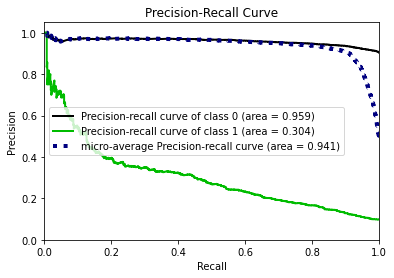

In [28]:
# Plot results
skplt.metrics.plot_confusion_matrix(y_test, y_pred_calibrated_xgb)
 
skplt.metrics.plot_precision_recall(y_test, calibrated_xgb.predict_proba(X_test))

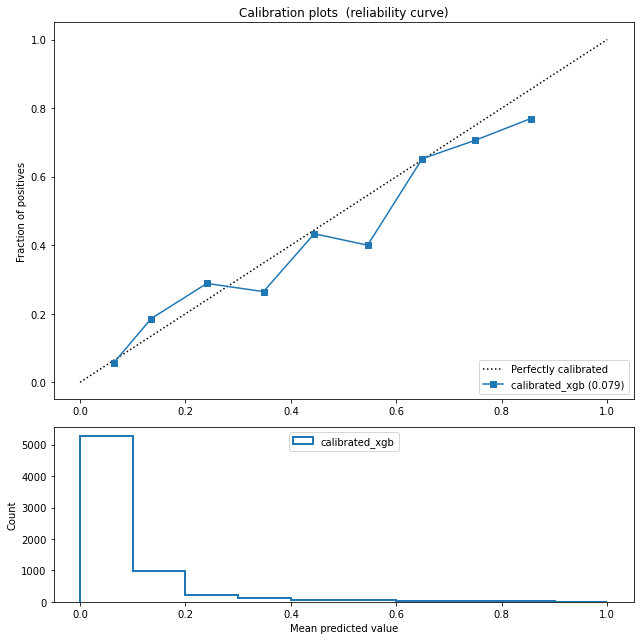

In [29]:
fig = plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba_calibrated_xgb, n_bins=10)
 
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('calibrated_xgb',brier_score_loss(y_test, y_pred_proba_calibrated_xgb)))
ax2.hist(y_pred_proba_calibrated_xgb, range=(0, 1), bins=10, label='calibrated_xgb',
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

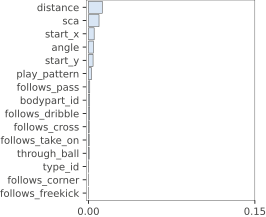

In [30]:
from rfpimp import * # pip install rfpimp first
imp = importances(calibrated_xgb, X1, y, n_samples=-1, metric='brier_score_loss')
viz = plot_importances(imp)
viz